In [11]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import lifetimes
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data

# Reload cleaned data
df = pd.read_csv("cleaned_data2.csv")

# make sure the cleaned data is still clean
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df = df[(df["Quantity"] > 0) & (df["Price"] > 0)]
df = df[~df["Invoice"].astype(str).str.contains("C", na=False)]
df.dropna(subset=['Customer ID'], inplace=True)
df["Total_Price"] = df["Quantity"] * df["Price"]

In [ ]:
'''In this chapter, I am going to some changes to the dataset.
Then I am going to create df_cltv and then apply the two models.
They are BetaGeoFitter and GammaGammaFitter models.
I am going to use the BetaGeoFilter model to predict how often shop of customer.
I am going to use the GammaGammaFilter model to predict how much profit a customer will bring.
And then I am going to analyze the data.'''
#Lets begin the mathematical operations for CLTV analysis.

'In this chapter, I am going to some changes to the dataset.\nThen I am going to create df_cltv and then apply the two models.\nThey are BetaGeoFitter and GammaGammaFitter models.\nI am going to use the BetaGeoFilter model to predict how often shop of customer.\nI am going to use the GammaGammaFilter model to predict how much profit a customer will bring.\nAnd then I am going to analyze the data.'

In [9]:
#AGAIN we will use this dataset for CLTV analysis, so we load it here to use cleaned data directly.
cleaned_data2 = df.copy()
print("🚀 ready for RFM analysis!")
cleaned_data2.head()

🚀 ready for RFM analysis!


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total_Price
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


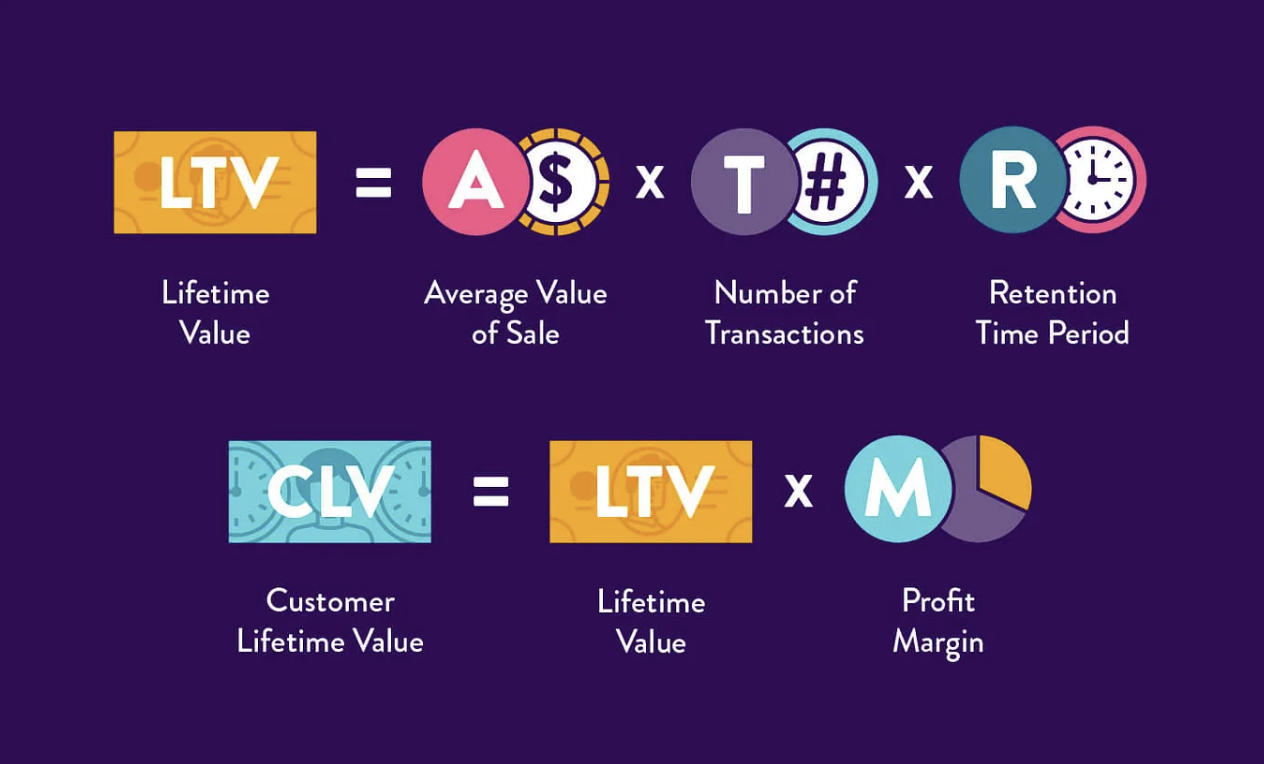

In [12]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return up_limit, low_limit

def replace_with_threshold(dataframe, variable):
    up_limit, low_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

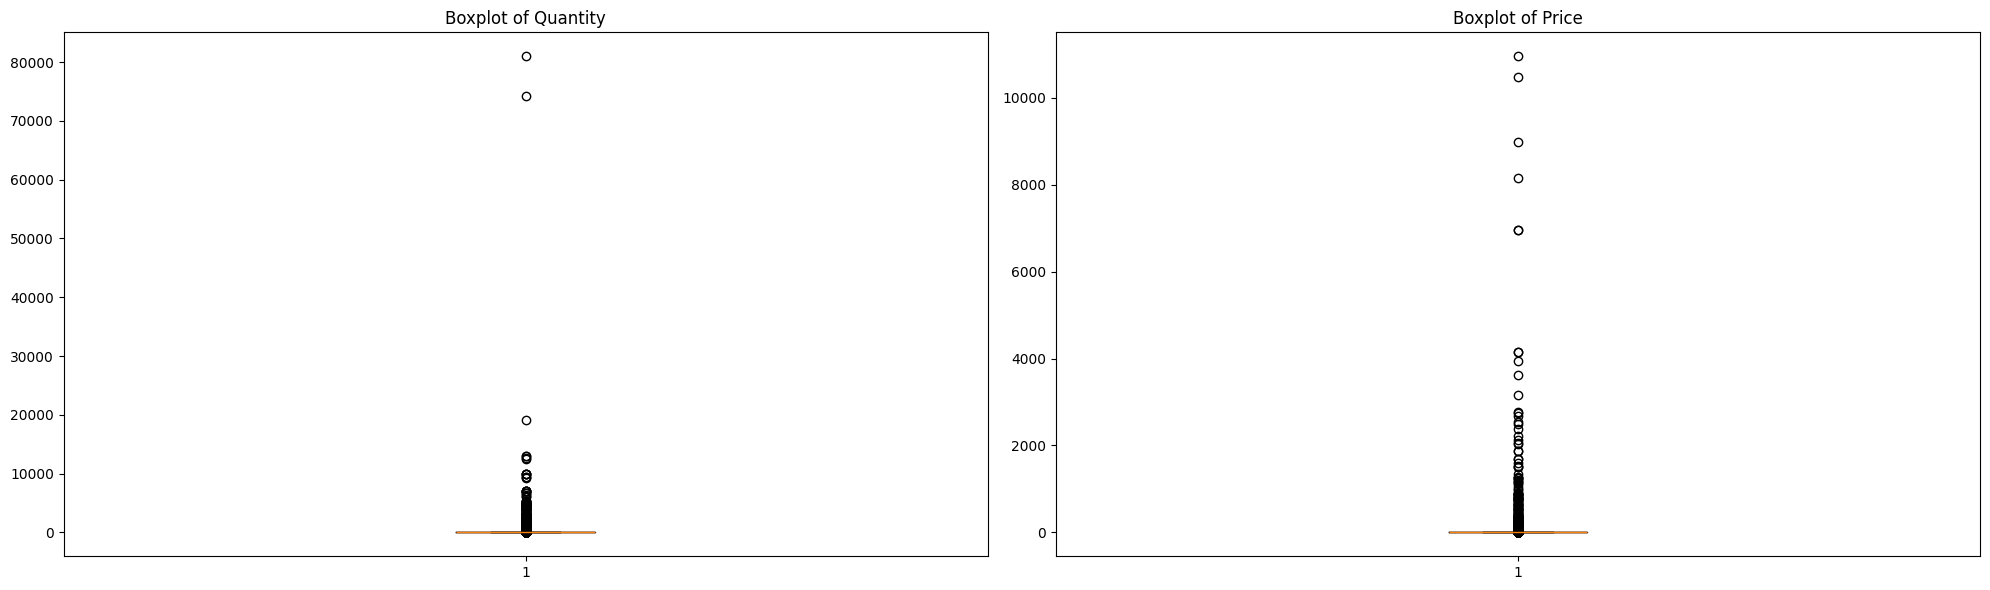

In [16]:
# we can look at the boxplots of Quantity and Price to see the outliers
# before applying the outlier treatment
f, ax = plt.subplots(1, 2, figsize=(20, 6)) 
col_list = ["Quantity", "Price"]

for i in range(0, 2):
    ax[i].boxplot(cleaned_data2[col_list[i]], vert=0)
    ax[i].set_title(f"Boxplot of {col_list[i]}")

plt.tight_layout() 
plt.show()

In [18]:
replace_with_threshold(cleaned_data2, "Quantity")
replace_with_threshold(cleaned_data2, "Price")

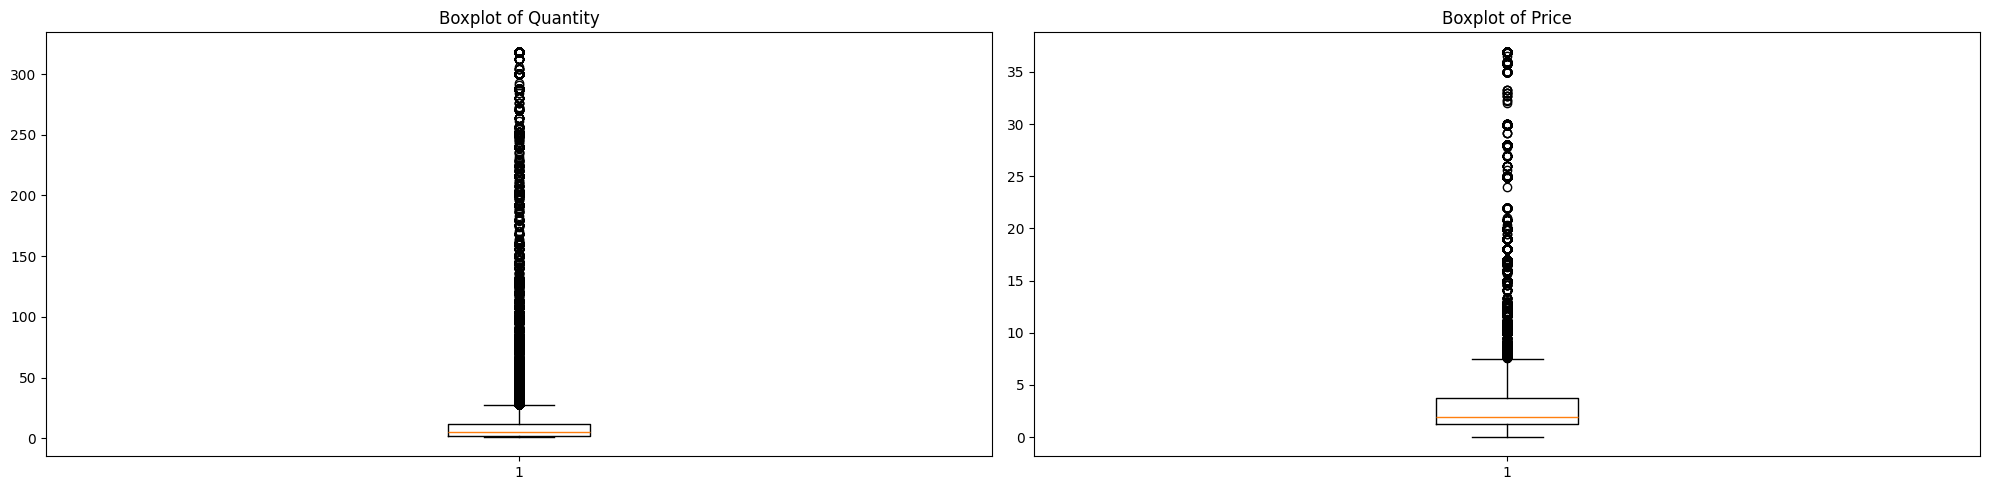

In [20]:
# Subplot düzenini 1 satır, 2 sütun (1, 2) yaparak yan yana diziyoruz.
f, ax = plt.subplots(1, 2, figsize=(20, 5)) 
col_list = ["Quantity", "Price"]

for i in range(0, 2):
    # vert=0 boxplot'un kendisini yatay yapar, (1, 2) ise yerleşimi yan yana yapar.
    ax[i].boxplot(cleaned_data2[col_list[i]], vert=0)
    ax[i].set_title(f"Boxplot of {col_list[i]}")

plt.tight_layout() # Grafiklerin birbirine girmesini önler.
plt.show()

In [21]:
#Prepare CLTV DataFrame
cleaned_data2["InvoiceDate"].max()


Timestamp('2011-12-09 12:50:00')

In [ ]:
'''
Recency: Time since the last purchase. Weekly. (User Specific)
NEW!! T: Customer's age. Weekly. (how long before the analysis date the first purchase was made)
Frequency: Total number of repeat purchases (frequency > 1)
Monetary: Average earnings per purchase
'''

In [33]:
today_date = dt.datetime(2011, 12, 11)

# Create the df_cltv dataframe.
df_cltv = cleaned_data2.groupby("Customer ID").agg({"InvoiceDate" : [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days, # recency
                                                  lambda InvoiceDate: (today_date - InvoiceDate.min()).days], # T
                                         "Invoice" : lambda Invoice: Invoice.nunique(), # frequnecy
                                         "Total_Price": lambda Total_Price: Total_Price.sum()}) # monetary

In [34]:
df_cltv.head()

InvoiceDate             Invoice Total_Price
             <lambda_0> <lambda_1> <lambda>    <lambda>
Customer ID                                            
12346.0             400        726       12      704.10
12347.0             402        405        8     5633.32
12348.0             362        439        5     1991.86
12349.0             570        590        4     3786.50
12350.0               0        311        1      331.34

In [35]:
# I remove the column names of df_cltv because I am going to change them.
df_cltv.columns = df_cltv.columns.droplevel(0)

In [36]:
df_cltv.head()

,<lambda_0>,<lambda_1>,<lambda>,<lambda>
Customer ID,,,,
12346.0,400,726,12,704.10
12347.0,402,405,8,5633.32
12348.0,362,439,5,1991.86
12349.0,570,590,4,3786.50
12350.0,0,311,1,331.34


In [38]:
# I specfy the column name of df_cltv
df_cltv.columns = ["recency", "T", "frequency", "monetary"]

In [39]:
df_cltv.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0,400,726,12,704.10
12347.0,402,405,8,5633.32
12348.0,362,439,5,1991.86
12349.0,570,590,4,3786.50
12350.0,0,311,1,331.34


In [40]:
# Average earnings per purchase
df_cltv["monetary"] = df_cltv["monetary"] / df_cltv["frequency"]

In [41]:
df_cltv.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0,400,726,12,58.675
12347.0,402,405,8,704.165
12348.0,362,439,5,398.372
12349.0,570,590,4,946.625
12350.0,0,311,1,331.340


In [42]:
df_cltv = df_cltv[df_cltv["frequency"] > 1]

In [43]:
df_cltv.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0,400,726,12,58.675
12347.0,402,405,8,704.165
12348.0,362,439,5,398.372
12349.0,570,590,4,946.625
12352.0,356,393,10,209.894


In [46]:
# Convert recency and T to weekly values
df_cltv["recency"] = df_cltv["recency"] / 7
df_cltv["T"] = df_cltv["T"] / 7

In [47]:
df_cltv.head()


,recency,T,frequency,monetary
Customer ID,,,,
12346.0,8.163265,14.816327,12,58.675
12347.0,8.204082,8.265306,8,704.165
12348.0,7.387755,8.959184,5,398.372
12349.0,11.632653,12.040816,4,946.625
12352.0,7.265306,8.020408,10,209.894


In [48]:
df_cltv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4255 entries, 12346.0 to 18287.0
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   recency    4255 non-null   float64
 1   T          4255 non-null   float64
 2   frequency  4255 non-null   int64  
 3   monetary   4255 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 166.2 KB


In [ ]:
#dataset ready for CLTV models using BG-NBD and Gamma-Gamma models
'''BG-NBD MODEL'''
#understand the purchasing behavior of customers
#predicted how customers will behave in the future.

In [49]:
# Model
bgf = BetaGeoFitter(penalizer_coef = 0.001)

# fit with frequency, recency, and T values.
bgf.fit(df_cltv["frequency"],
       df_cltv["recency"],
       df_cltv["T"])

<lifetimes.BetaGeoFitter: fitted with 4255 subjects, a: 0.24, alpha: 1.61, b: 3.06, r: 1.71>

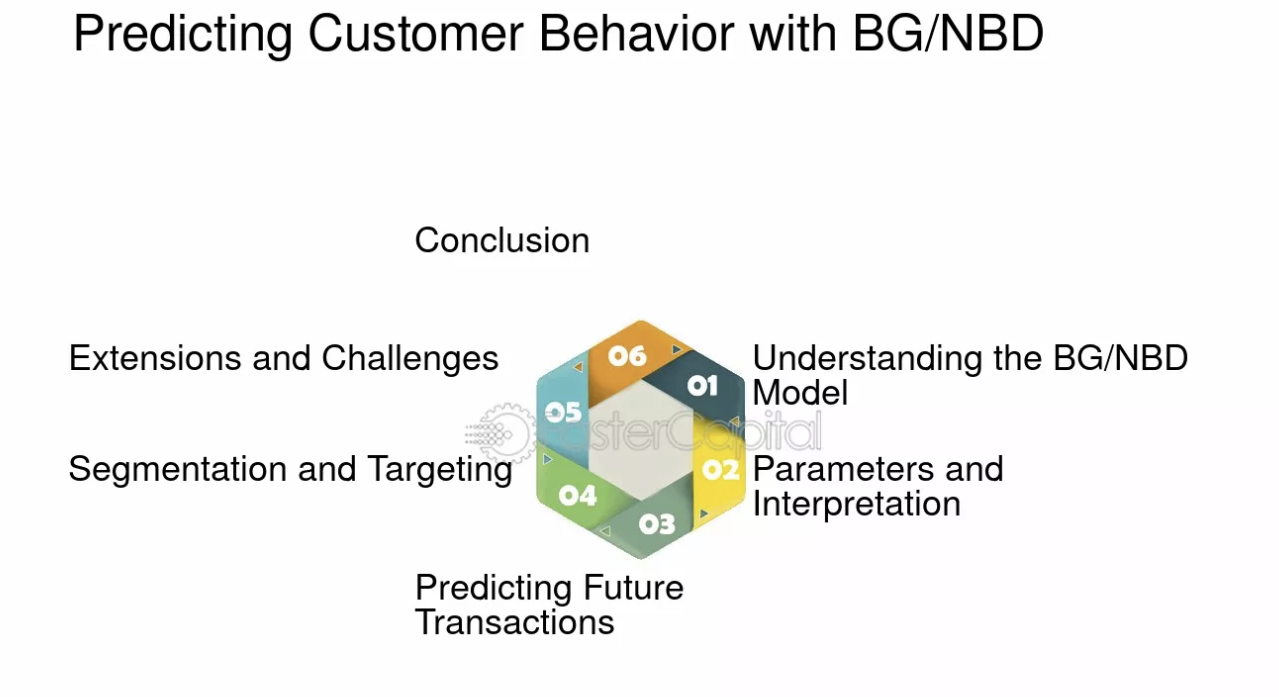

In [50]:
# Calculating one monthly values
bgf.predict(4, # this is 4 weeks for one month
           df_cltv["frequency"],
           df_cltv["recency"],
           df_cltv["T"]).sort_values(ascending = False).head(10)

Customer ID
14911.0    93.196052
12748.0    79.021234
17841.0    49.614021
15311.0    48.903380
13089.0    47.713814
14606.0    45.257800
14156.0    36.371362
14646.0    35.610243
18102.0    34.197211
13694.0    33.783249
dtype: float64

In [52]:
# Calculating three monthly values
bgf.predict(4*3, 
           df_cltv["frequency"],
           df_cltv["recency"],
           df_cltv["T"]).sort_values(ascending = False).head(10)

Customer ID
14911.0    267.861360
12748.0    227.095022
17841.0    142.599449
15311.0    140.562784
13089.0    137.138404
14606.0    130.074805
14156.0    104.545200
14646.0    102.353739
18102.0     98.296749
13694.0     97.095287
dtype: float64

In [54]:
# Adding the three monthly values to the df_cltv
df_cltv["expected_purc_3_month"] = bgf.predict(4*3, 
                                               df_cltv["frequency"],
                                               df_cltv["recency"],
                                               df_cltv["T"])

In [55]:
df_cltv.head()

,recency,T,frequency,monetary,expected_purc_3_month
Customer ID,,,,,
12346.0,8.163265,14.816327,12,58.675,0.429065
12347.0,8.204082,8.265306,8,704.165,10.417859
12348.0,7.387755,8.959184,5,398.372,6.318169
12349.0,11.632653,12.040816,4,946.625,4.449769
12352.0,7.265306,8.020408,10,209.894,12.530613


In [57]:
# Calculating six monthly values
bgf.predict(4*6, 
           df_cltv["frequency"],
           df_cltv["recency"],
           df_cltv["T"]).sort_values(ascending = False).head(10)

Customer ID
14911.0    509.692494
12748.0    432.076744
17841.0    271.341885
15311.0    267.476710
13089.0    260.951318
14606.0    247.502494
14156.0    198.944430
14646.0    194.767675
18102.0    187.055501
13694.0    184.748872
dtype: float64

In [59]:
# Adding the six monthly values to the df_cltv
df_cltv["expected_purc_6_month"] = bgf.predict(4*6, 
                                               df_cltv["frequency"],
                                               df_cltv["recency"],
                                               df_cltv["T"])

In [60]:
df_cltv.head()

,recency,T,frequency,monetary,expected_purc_3_month,expected_purc_6_month
Customer ID,,,,,,
12346.0,8.163265,14.816327,12,58.675,0.429065,0.816998
12347.0,8.204082,8.265306,8,704.165,10.417859,19.528499
12348.0,7.387755,8.959184,5,398.372,6.318169,11.878661
12349.0,11.632653,12.040816,4,946.625,4.449769,8.437708
12352.0,7.265306,8.020408,10,209.894,12.530613,23.462463


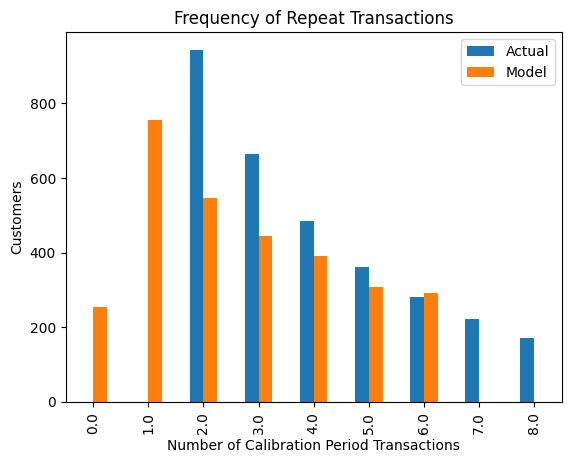

In [ ]:
from lifetimes.plotting import plot_period_transactions
#this is to visualize the model fit. as we can see the model fits well.because the predicted values and the actual values are very close to each other.
plot_period_transactions(bgf)
plt.show()

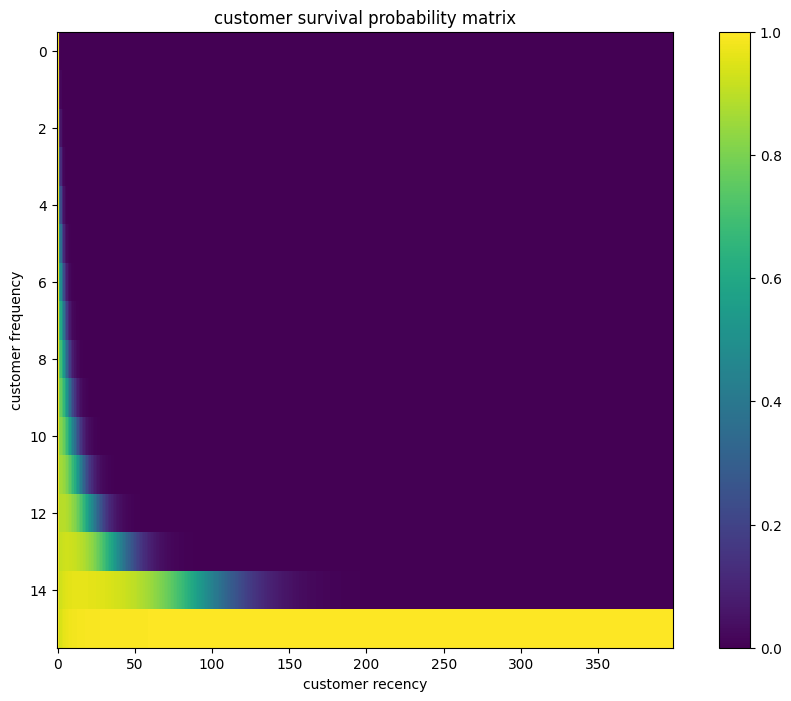

In [72]:
from lifetimes.plotting import plot_probability_alive_matrix

plt.figure(figsize=(12, 8))
plot_probability_alive_matrix(bgf)
plt.title("customer survival probability matrix")
plt.xlabel("customer recency")
plt.ylabel("customer frequency")
plt.show()

In [ ]:
#_______________the explanations for the plot above______________
'''Yellow Stripe: Indicates that customers who have been with you 
for a long time and have established a certain frequency have a very
strong level of loyalty.

Purple Stripe: Proves that low-frequency customers have a much higher
risk of dropping out of the system, therefore it makes sense to 
take "loyalty-enhancing" actions targeting them.'''

In [ ]:
#now we will use Gamma-Gamma model to predict the average profit of the customers.
'''Gammma-Gamma MODEL'''
#for future monetary value prediction
#with using gamma-gamma model
#i will calculate the expected average profit of the customers.

In [74]:
# Model
ggf = GammaGammaFitter(penalizer_coef = 0.01)

# fitting with frequency adn monetary values
ggf.fit(df_cltv["frequency"], df_cltv["monetary"])

<lifetimes.GammaGammaFitter: fitted with 4255 subjects, p: 3.80, q: 0.34, v: 3.74>

In [75]:
ggf.conditional_expected_average_profit(df_cltv["frequency"], df_cltv["monetary"]).sort_values(ascending = False).head(10)

Customer ID
12357.0    6182.832222
12590.0    5035.246014
12415.0    5034.565149
14091.0    4997.184588
14088.0    4029.927611
18102.0    3731.148363
12753.0    3678.298354
12409.0    3430.983383
15749.0    3430.906809
14646.0    3365.300894
dtype: float64

In [76]:
# Adding the prediction values to df_rfm.
df_cltv["expected_average_profit"] = ggf.conditional_expected_average_profit(df_cltv["frequency"], df_cltv["monetary"])

In [77]:
df_cltv.head()

,recency,T,frequency,monetary,expected_purc_3_month,expected_purc_6_month,expected_average_profit
Customer ID,,,,,,,
12346.0,8.163265,14.816327,12,58.675,0.429065,0.816998,59.850169
12347.0,8.204082,8.265306,8,704.165,10.417859,19.528499,720.215140
12348.0,7.387755,8.959184,5,398.372,6.318169,11.878661,413.432341
12349.0,11.632653,12.040816,4,946.625,4.449769,8.437708,990.417244
12352.0,7.265306,8.020408,10,209.894,12.530613,23.462463,213.971813


In [ ]:
#we are understand the profitabilty of the customers.

In [78]:
cltv = ggf.customer_lifetime_value(bgf,
                                  df_cltv["frequency"],
                                  df_cltv["recency"],
                                  df_cltv["T"],
                                  df_cltv["monetary"],
                                  time = 6, # six mounth
                                  freq = "W",
                                  discount_rate = 0.01)

In [79]:
cltv.head(10)

Customer ID
12346.0       50.983355
12347.0    14640.828725
12348.0     5113.712930
12349.0     8709.475811
12352.0     5225.356334
12353.0     1243.114179
12355.0     2554.950270
12356.0    16776.619809
12357.0    60706.376886
12358.0     7007.746655
Name: clv, dtype: float64

In [80]:
# Adding the cltv values to the df_cltv.
df_cltv["cltv"] = cltv

In [81]:
df_cltv.head()

,recency,T,frequency,monetary,expected_purc_3_month,expected_purc_6_month,expected_average_profit,cltv
Customer ID,,,,,,,,
12346.0,8.163265,14.816327,12,58.675,0.429065,0.816998,59.850169,50.983355
12347.0,8.204082,8.265306,8,704.165,10.417859,19.528499,720.215140,14640.828725
12348.0,7.387755,8.959184,5,398.372,6.318169,11.878661,413.432341,5113.712930
12349.0,11.632653,12.040816,4,946.625,4.449769,8.437708,990.417244,8709.475811
12352.0,7.265306,8.020408,10,209.894,12.530613,23.462463,213.971813,5225.356334


In [ ]:
#Segmentasion 
'''In this chapter, I split the cltv values into segments.'''


In [83]:
df_cltv["segment"] = pd.qcut(df_cltv["cltv"], 4, labels = ["D", "C", "B", "A"])

In [84]:
df_cltv.head()

,recency,T,frequency,monetary,expected_purc_3_month,expected_purc_6_month,expected_average_profit,cltv,segment
Customer ID,,,,,,,,,
12346.0,8.163265,14.816327,12,58.675,0.429065,0.816998,59.850169,50.983355,D
12347.0,8.204082,8.265306,8,704.165,10.417859,19.528499,720.215140,14640.828725,A
12348.0,7.387755,8.959184,5,398.372,6.318169,11.878661,413.432341,5113.712930,B
12349.0,11.632653,12.040816,4,946.625,4.449769,8.437708,990.417244,8709.475811,A
12352.0,7.265306,8.020408,10,209.894,12.530613,23.462463,213.971813,5225.356334,B


In [85]:
#Review The CLTV DataFrame
df_cltv.head()

,recency,T,frequency,monetary,expected_purc_3_month,expected_purc_6_month,expected_average_profit,cltv,segment
Customer ID,,,,,,,,,
12346.0,8.163265,14.816327,12,58.675,0.429065,0.816998,59.850169,50.983355,D
12347.0,8.204082,8.265306,8,704.165,10.417859,19.528499,720.215140,14640.828725,A
12348.0,7.387755,8.959184,5,398.372,6.318169,11.878661,413.432341,5113.712930,B
12349.0,11.632653,12.040816,4,946.625,4.449769,8.437708,990.417244,8709.475811,A
12352.0,7.265306,8.020408,10,209.894,12.530613,23.462463,213.971813,5225.356334,B


In [86]:
df_cltv.groupby("segment").agg({"count", "mean", "sum"})

recency                             T                   \
                  sum      mean count           sum       mean count   
segment                                                                
D         4200.061224  3.947426  1064  12356.183673  11.612955  1064   
C         8918.612245  8.382154  1064  11374.204082  10.690041  1064   
B         9391.102041  8.834527  1063  10625.346939   9.995623  1063   
A        10241.775510  9.625729  1064  10873.795918  10.219733  1064   

        frequency                        monetary  ... expected_purc_3_month  \
              sum       mean count            sum  ...                 count   
segment                                            ...                         
D            4217   3.963346  1064  270554.113982  ...                  1064   
C            4770   4.483083  1064  275069.322920  ...                  1064   
B            7512   7.066792  1063  372671.063950  ...                  1063   
A           18847  17.713346  1064  636329.029243  ...                  1064   

        expected_purc_6_month                  expected_average_profit  \
                          sum       mean count                     sum   
segment                                                                  
D                 2327.985490   2.187956  1064           290027.366556   
C                 9616.193249   9.037776  1064           292227.340052   
B                15995.269195  15.047290  1063           389446.115889   
A                33508.801070  31.493234  1064           654365.594580   

                                   cltv                      
               mean count           sum          mean count  
segment                                                      
D        272.582111  1064  4.166813e+05    391.617746  1064  
C        274.649756  1064  2.287377e+06   2149.789947  1064  
B        366.365114  1063  5.153651e+06   4848.213949  1063  
A        615.005258  1064  2.074474e+07  19496.932736  1064  

[4 rows x 24 columns]

In [87]:
df_cltv.sort_values(by = "recency", ascending = False).head()

,recency,T,frequency,monetary,expected_purc_3_month,expected_purc_6_month,expected_average_profit,cltv,segment
Customer ID,,,,,,,,,
15311.0,15.061224,15.081633,208,560.808245,140.562784,267.476710,561.293313,156526.170017,A
18102.0,15.061224,15.081633,145,3726.668724,98.296749,187.055501,3731.148363,727655.511654,A
13599.0,15.040816,15.081633,33,307.836364,23.148449,44.067476,309.573495,14223.704061,A
13777.0,15.040816,15.061224,61,907.203033,41.989089,79.913655,909.846038,75806.684891,A
14911.0,15.040816,15.081633,398,709.398844,267.861360,509.692494,709.716895,377140.009821,A


In [88]:
def check_cltv_best_and_worst(column):
    print(f"############ Top five - {column} ############")
    print(df_cltv.sort_values(by = column, ascending = False).head())
    print(f"############ Bottom five - {column} ############")
    print(df_cltv.sort_values(by = column, ascending = True).head())

In [89]:
check_cltv_best_and_worst("recency")

############ Top five - recency ############
               recency          T  frequency     monetary  \
Customer ID                                                 
15311.0      15.061224  15.081633        208   560.808245   
18102.0      15.061224  15.081633        145  3726.668724   
13599.0      15.040816  15.081633         33   307.836364   
13777.0      15.040816  15.061224         61   907.203033   
14911.0      15.040816  15.081633        398   709.398844   

             expected_purc_3_month  expected_purc_6_month  \
Customer ID                                                 
15311.0                 140.562784             267.476710   
18102.0                  98.296749             187.055501   
13599.0                  23.148449              44.067476   
13777.0                  41.989089              79.913655   
14911.0                 267.861360             509.692494   

             expected_average_profit           cltv segment  
Customer ID                          

In [90]:
check_cltv_best_and_worst("frequency")

############ Top five - frequency ############
               recency          T  frequency    monetary  \
Customer ID                                                
14911.0      15.040816  15.081633        398  709.398844   
12748.0      14.979592  15.020408        336  156.948274   
17841.0      15.000000  15.061224        211  335.401469   
15311.0      15.061224  15.081633        208  560.808245   
13089.0      14.979592  15.061224        203  575.018867   

             expected_purc_3_month  expected_purc_6_month  \
Customer ID                                                 
14911.0                 267.861360             509.692494   
12748.0                 227.095022             432.076744   
17841.0                 142.599449             271.341885   
15311.0                 140.562784             267.476710   
13089.0                 137.138404             260.951318   

             expected_average_profit           cltv segment  
Customer ID                               

In [91]:
check_cltv_best_and_worst("monetary")

############ Top five - monetary ############
               recency          T  frequency     monetary  \
Customer ID                                                 
12357.0       7.244898   7.938776          3  5824.866667   
12415.0      10.265306  10.775510         28  5003.309821   
12590.0       0.000000   4.326531          2  4597.612500   
14091.0       0.897959  14.265306          2  4562.845000   
14088.0       8.367347   8.612245         16  3986.098750   

             expected_purc_3_month  expected_purc_6_month  \
Customer ID                                                 
12357.0                   5.028629               9.431606   
12415.0                  25.703067              48.480177   
12590.0                   0.774161               1.430448   
14091.0                   0.046793               0.089242   
14088.0                  18.457047              34.609827   

             expected_average_profit           cltv segment  
Customer ID                         

In [92]:
df_cltv.head()

,recency,T,frequency,monetary,expected_purc_3_month,expected_purc_6_month,expected_average_profit,cltv,segment
Customer ID,,,,,,,,,
12346.0,8.163265,14.816327,12,58.675,0.429065,0.816998,59.850169,50.983355,D
12347.0,8.204082,8.265306,8,704.165,10.417859,19.528499,720.215140,14640.828725,A
12348.0,7.387755,8.959184,5,398.372,6.318169,11.878661,413.432341,5113.712930,B
12349.0,11.632653,12.040816,4,946.625,4.449769,8.437708,990.417244,8709.475811,A
12352.0,7.265306,8.020408,10,209.894,12.530613,23.462463,213.971813,5225.356334,B


In [95]:
# Correlation between the columns.
df_cltv.select_dtypes(include=['number']).corr()


,recency,T,frequency,monetary,expected_purc_3_month,expected_purc_6_month,expected_average_profit,cltv
recency,1.000000,0.705617,0.379024,0.106827,0.269527,0.280469,0.082844,0.161859
T,0.705617,1.000000,0.250568,0.055091,-0.054854,-0.039283,0.040087,0.025084
frequency,0.379024,0.250568,1.000000,0.153956,0.895350,0.902388,0.134247,0.598248
monetary,0.106827,0.055091,0.153956,1.000000,0.154780,0.155530,0.998876,0.501404
expected_purc_3_month,0.269527,-0.054854,0.895350,0.154780,1.000000,0.999795,0.136697,0.624666
expected_purc_6_month,0.280469,-0.039283,0.902388,0.155530,0.999795,1.000000,0.137276,0.626081
expected_average_profit,0.082844,0.040087,0.134247,0.998876,0.136697,0.137276,1.000000,0.481449
cltv,0.161859,0.025084,0.598248,0.501404,0.624666,0.626081,0.481449,1.000000


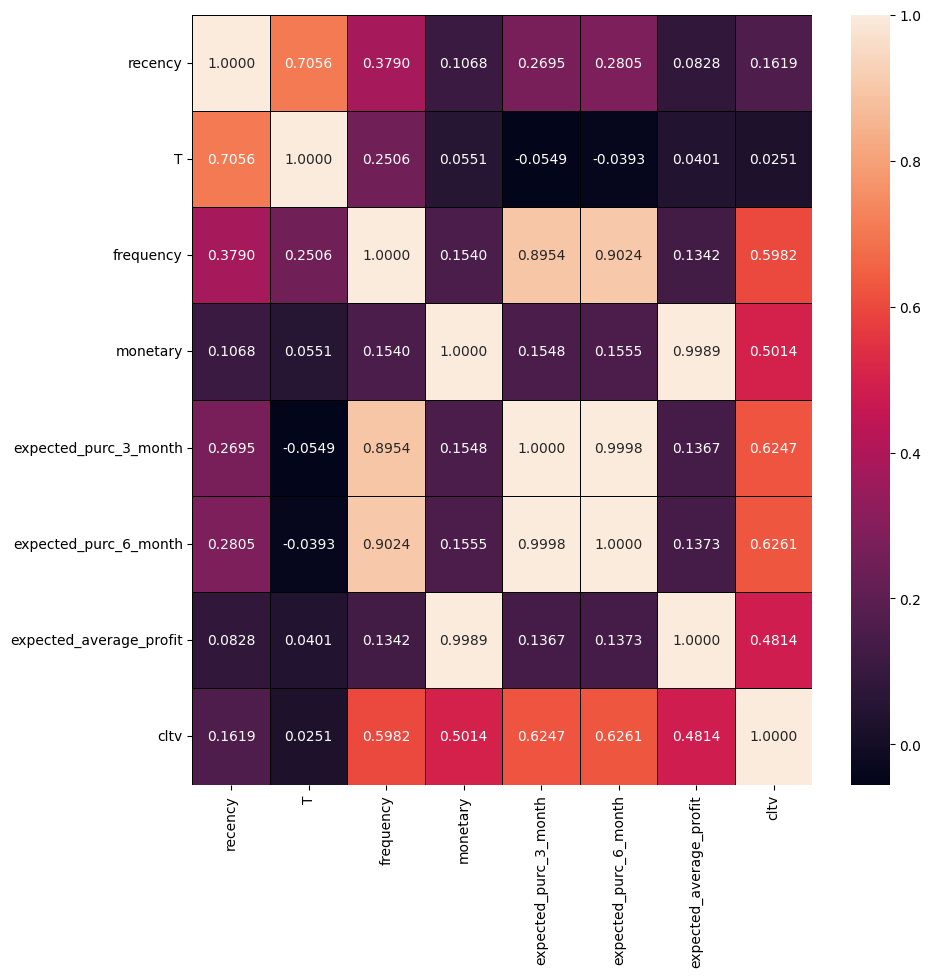

In [96]:
import seaborn as sns
# Visualization of correlation result with seaborn library heatmap.
f, ax = plt.subplots(figsize = (10,10))
sns.heatmap(df_cltv.select_dtypes(include=['number']).corr(), annot = True, linewidths=0.5, linecolor = "black", fmt = ".4f", ax = ax)
plt.show()

In [ ]:
'''above the chart,
-The Strongest Factor (Frequency):
CLTV value is most affected by expected_purc_6_month ($0.62$)
and past frequency ($0.60$); in other words, how often the customer
visits is more critical than how much they spend.

-Monetary Consistency: Past spending averages predict future profit
(expected_average_profit) almost perfectly ($0.99).

-Effect of Time: The customer's total age (T) does not affect future
shopping frequency ($-0.03); the model awards points to "active and
frequent customers," not "old friends."

-Linear Prediction: The perfect correlation between the 3-month and 
6-month predictions ($0.99$) proves the model is steadily growing 
its time projection.
'''

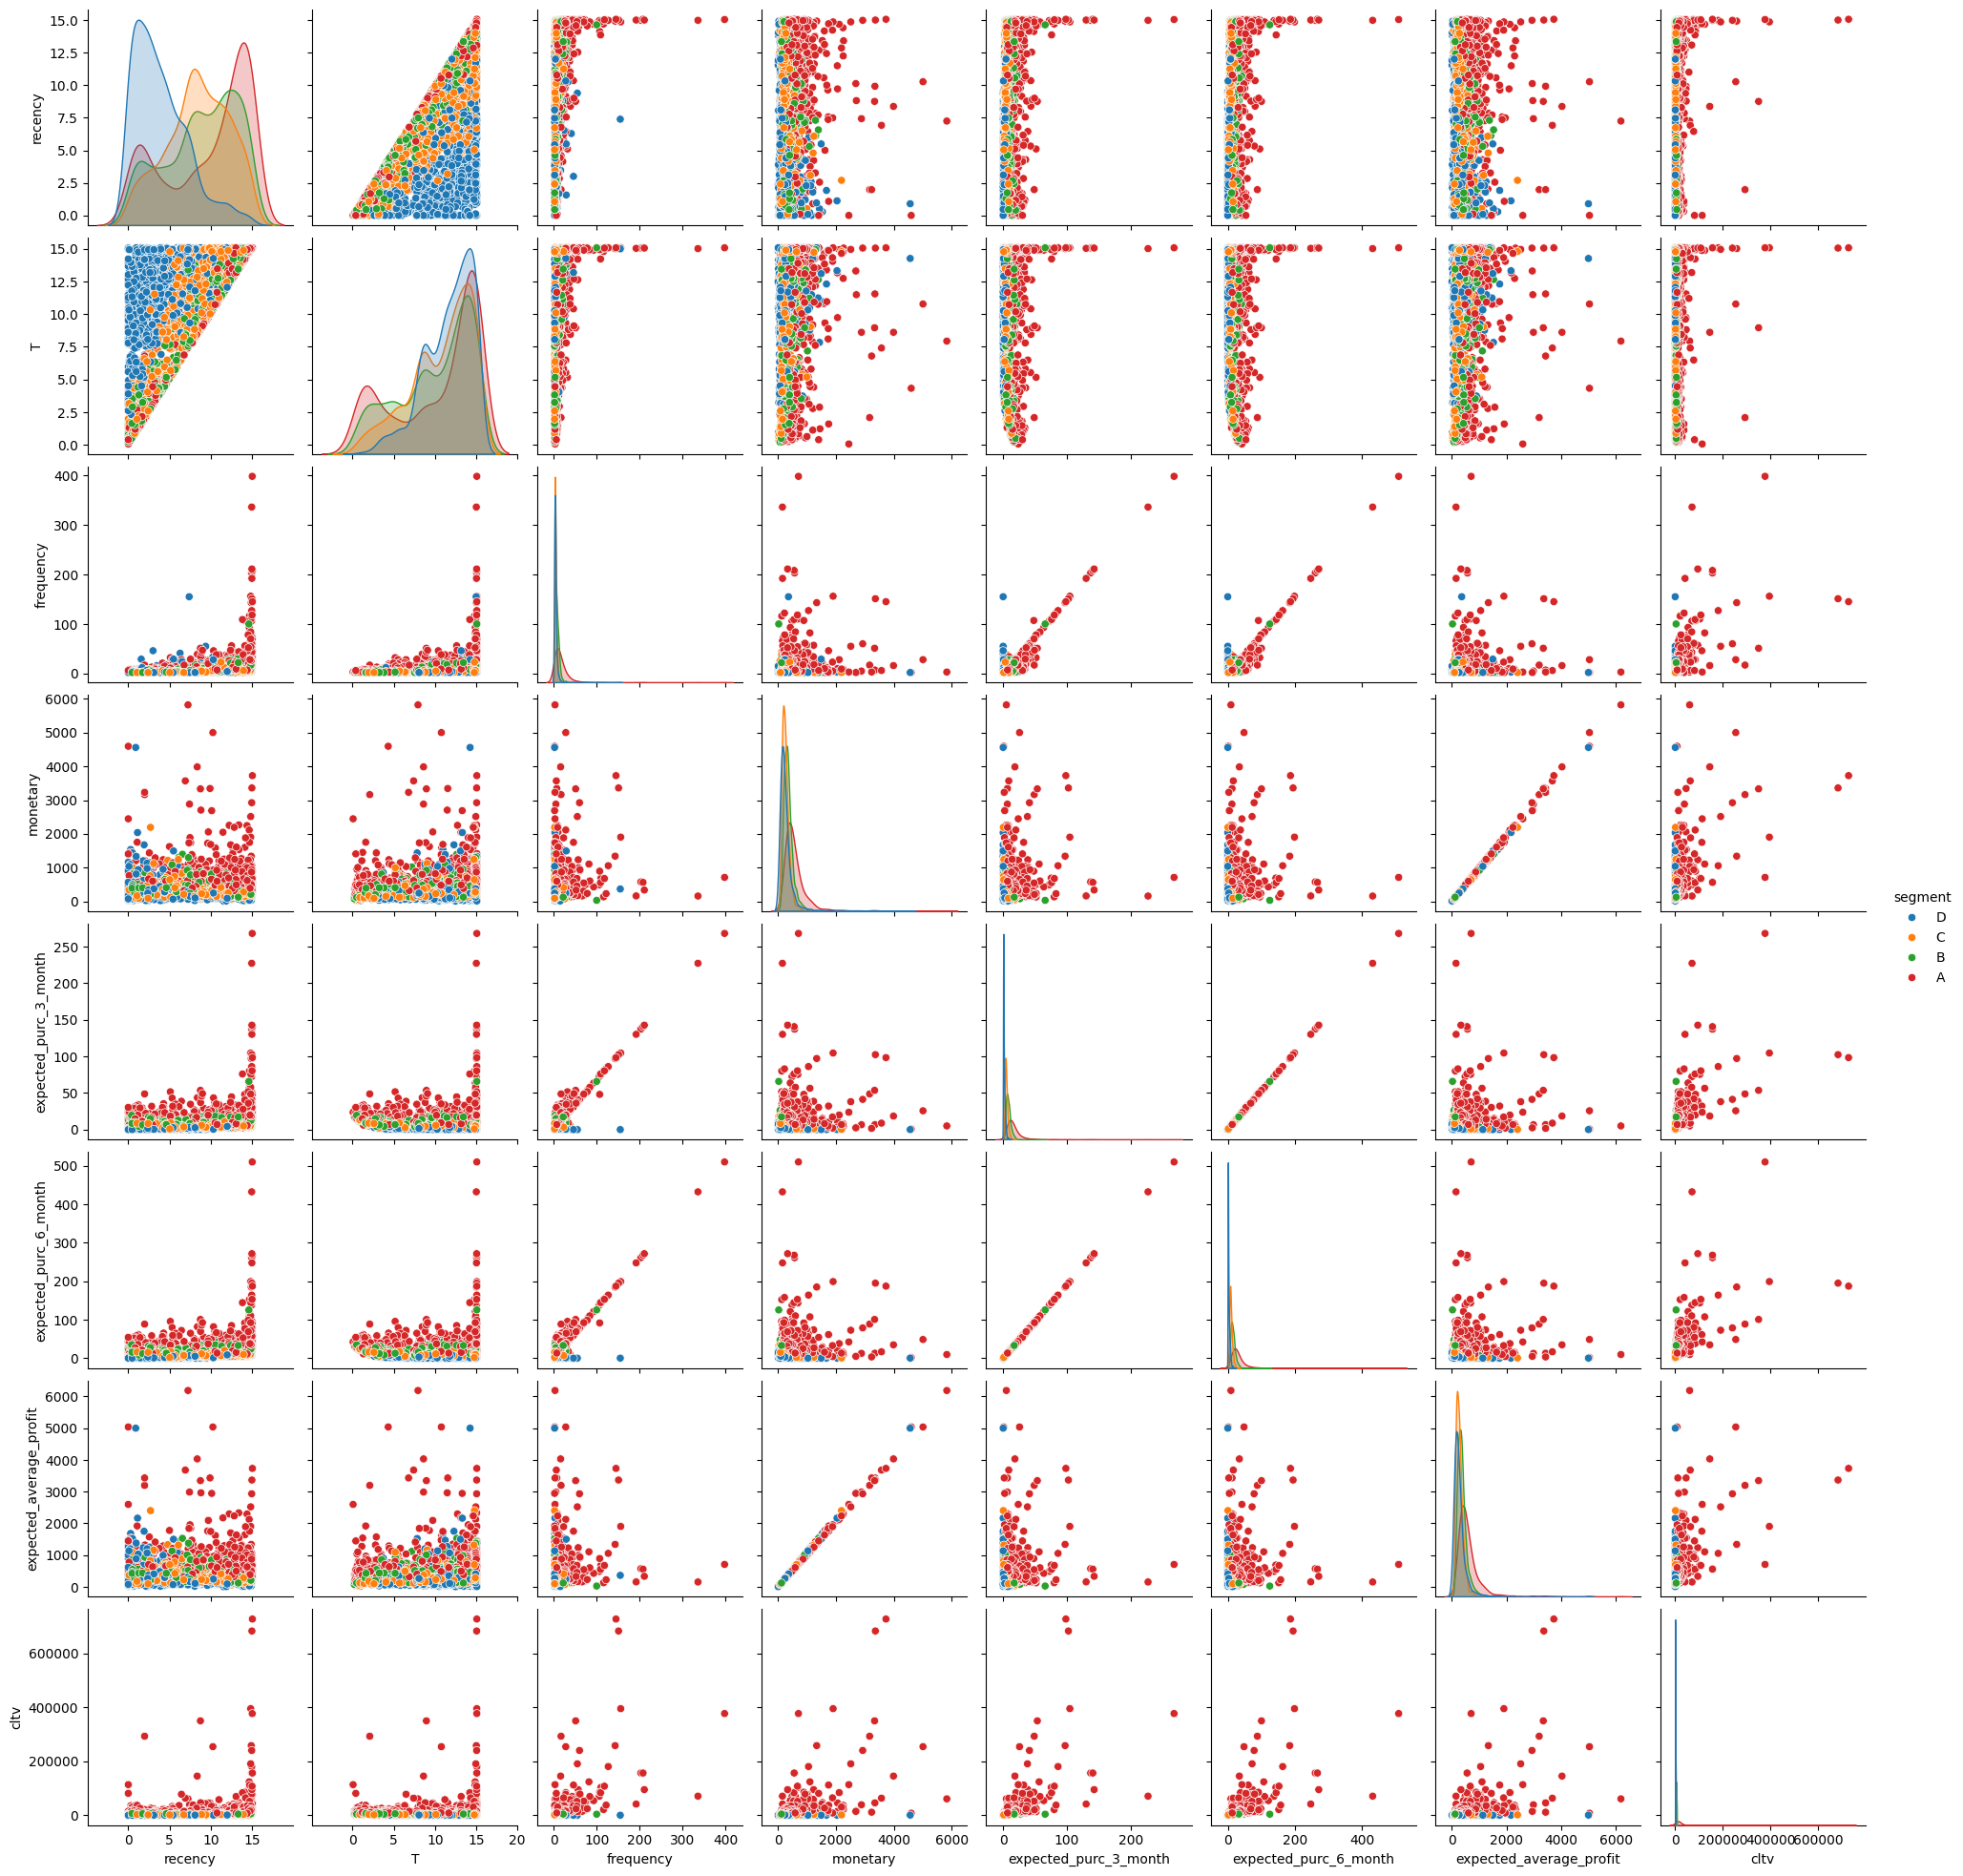

In [97]:
# Visualization of correlation results with seaborn library pairplot
sns.pairplot(df_cltv, hue = "segment")

In [ ]:
'''above the chart,
Segment Segregation: If you look at the cltv column in the lower right
of the graph, you can see that the red dots (Segment A) are completely 
detached from the others. This shows that your model has successfully 
identified the "most valuable" customers.

Frequency and Profit Relationship: The graphs between frequency and
monetary confirm that segment A comes very frequently and spends a lot 
each time.

Linear Predictions: That perfectly straight line between expected_purc_3_month 
and expected_purc_6_month is visual proof that the model has steadily
increased its predictions over time.

Monetary and Average Profit: The linear relationship between monetary 
and expected_average_profit shows how past spending directly reflects on 
future profit predictions.

Density Graphs (Diagonal): The peaks (histograms) descending from the top 
left to the bottom right whisper that the vast majority of the customer 
base is concentrated in low-value segments (D and C), while segment A is 
a small but very influential group.
'''

In [ ]:
segmenta = df_cltv.groupby("segment").agg({
    "cltv": ["count", "mean", "sum"],
    "expected_purc_6_month": ["mean", "sum"],
    "expected_average_profit": ["mean"]
})

segmenta.columns = [
    'Customer Count', 'Mean CLTV', 'Total CLTV',
    'Mean Expected Sales (6 Months)', 'Total Expected Sales (6 Months)',
    'Mean Expected Profit'
]

segmenta = segmenta.sort_values("Mean CLTV", ascending=False)
segmenta

,Customer Count,Mean CLTV,Total CLTV,Mean Expected Sales (6 Months),Total Expected Sales (6 Months),Mean Expected Profit
segment,,,,,,
A,1064,19496.932736,2.074474e+07,31.493234,33508.801070,615.005258
B,1063,4848.213949,5.153651e+06,15.047290,15995.269195,366.365114
C,1064,2149.789947,2.287377e+06,9.037776,9616.193249,274.649756
D,1064,391.617746,4.166813e+05,2.187956,2327.985490,272.582111


In [ ]:
'''above the table,
Segment,Characteristic,Business Strategy (Action Plan),Marketing Tool
A (Viziers), "Highest frequency and profit.", "Maintain loyalty, make them feel like VIPs.", Special Advisor / Early Access
B (Stars), "High frequency, moderate profit.", "Increase spending amount (Up-sell).", Basket Completion Suggestions
C (Potentials), "Medium frequency, risky zone.", "Re-engage (Retention).", "We Miss You" Coupons"
D (Sleeping Segments), "Low frequency, low profit.", "Cost-saving, automate tracking.", General Newsletter / Mass Mail
'''

In [ ]:
#churn risk analaysis
'''In this chapter, I am going to identify customers at risk of churn.'''
df_cltv.columns = [col.strip() for col in df_cltv.columns]


if "segment" not in df_cltv.columns:
    df_cltv = df_cltv.reset_index()


if "prob_alive" not in df_cltv.columns:
    df_cltv["prob_alive"] = bgf.conditional_probability_alive(df_cltv['frequency'], 
                                                              df_cltv['recency'], 
                                                              df_cltv['T'])


churn_risk_table = df_cltv[(df_cltv["prob_alive"] < 0.5) & 
                           (df_cltv["segment"] == "A")].sort_values("cltv", ascending=False)

churn_risk_table.head(10)

,recency,T,frequency,monetary,expected_purc_3_month,expected_purc_6_month,expected_average_profit,cltv,segment,prob_alive
Customer ID,,,,,,,,,,
15749.0,1.979592,6.795918,3,3231.713333,1.684377,3.145928,3430.906809,11231.517796,A,0.279255
12980.0,11.816327,15.061224,21,773.608571,6.365902,12.121335,780.217457,9860.687852,A,0.416565
17509.0,0.102041,1.306122,8,764.392500,6.131011,11.050164,781.774513,8960.720257,A,0.192787
16745.0,4.591837,6.367347,17,423.194118,10.483520,19.495756,427.769604,8674.545711,A,0.419802
14439.0,7.489796,14.040816,5,1888.608000,2.112589,4.021292,1957.105591,8205.538599,A,0.439448
15768.0,12.653061,15.040816,34,452.615588,9.070347,17.265617,455.042169,8191.442359,A,0.377225
12590.0,0.000000,4.326531,2,4597.612500,0.774161,1.430448,5035.246014,7487.401924,A,0.118462


In [ ]:
'''above the Churn analysis table,
This shows "those whose departure would hurt the most." Here's the logic behind this table:

Segment A (Most Valuable): These customers are normally your most loyal, most frequent, and highest-spending (high-value) customers.

prob_alive < 0.50 (Low Vitality): The BG-NBD model calculated that their current silence is not normal by looking at their past shopping habits (Recency and Frequency). In other words, it says, "This guy normally came every week; if he hasn't come for a month, he's probably left us."

Why do we say "Risk"?: These individuals still appear to have high cltv values ​​because if you can bring them back (i.e., if they are still alive), the potential money they can bring you is very high.

What Should You Do With These Customers?
This incoming list is your **"Emergency Recovery List"**. Assuming they are churn, you can take the following actions:

Recovery Campaign: Offer a very attractive discount, exclusive to them and not given to other segments, with a "We missed you" theme. etc.

Survey/Feedback: Send a short satisfaction survey to understand why they didn't come.

Personal Contact: If the number is low, contact them directly through a customer representative.
'''

In [ ]:
#___________________________________________________________________#
'''We have successfully completed our CRM analysis,
I enjoyed it very much. See you in another data science project!'''
#___________________________________________________________________#

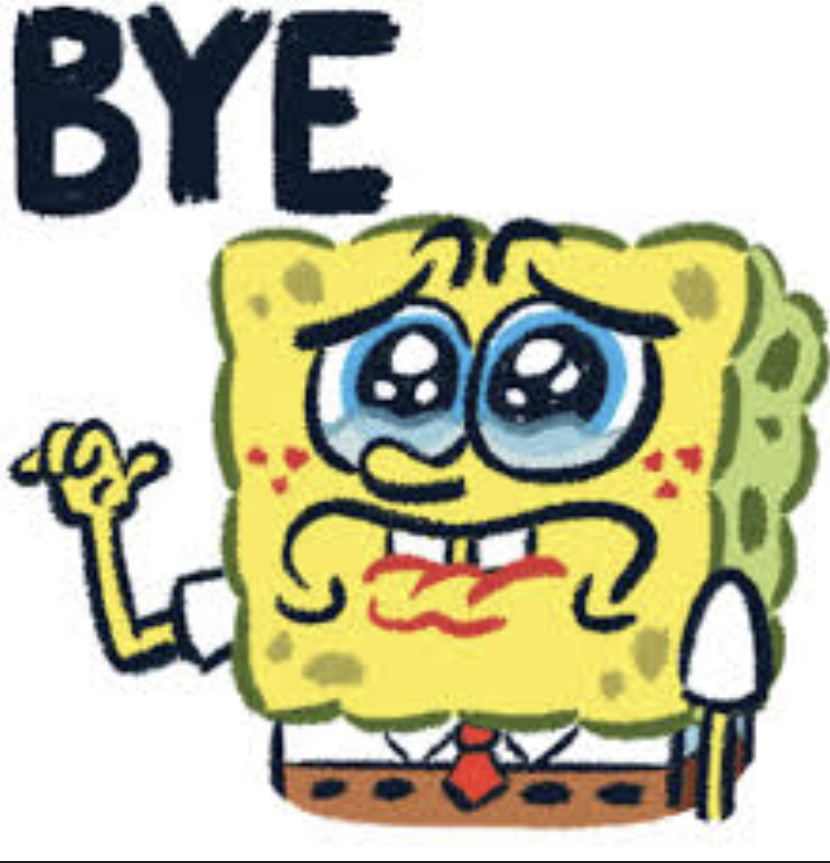

In [116]:
# Save the final CLTV segmentation dataframe
df_cltv.to_csv("final_cltv_segmentation.csv", index=True)

#risky customers separately (to make an "Alarm" list in Power BI)
churn_risk_table.to_csv("churn_risk_customers.csv", index=False)